# Zero Curves and Spot Curves

Interest rate curves are commonly provided as either zero curves or spot curves.  They are different.

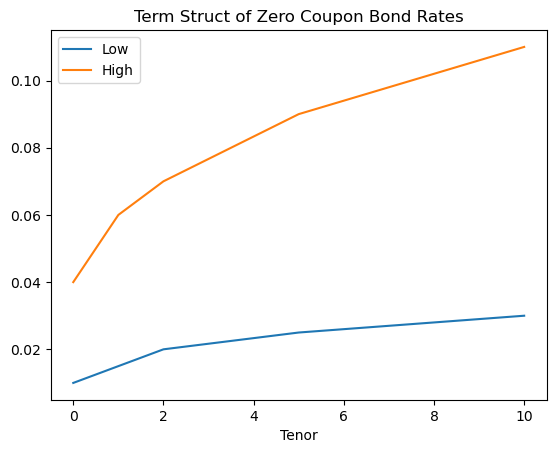

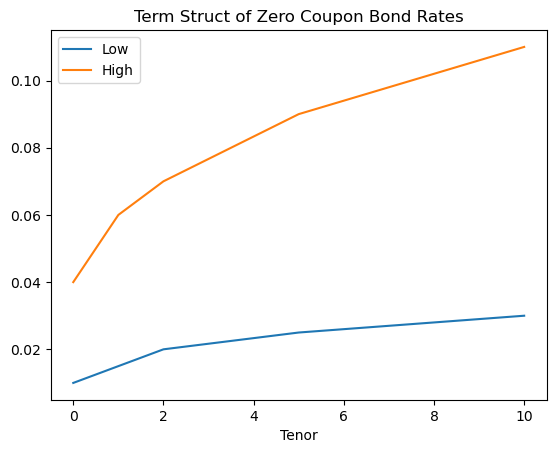

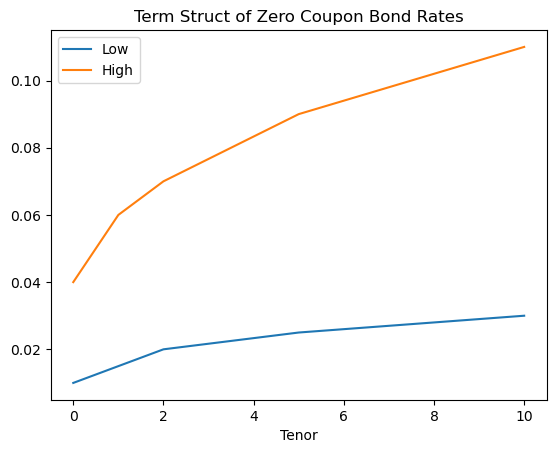

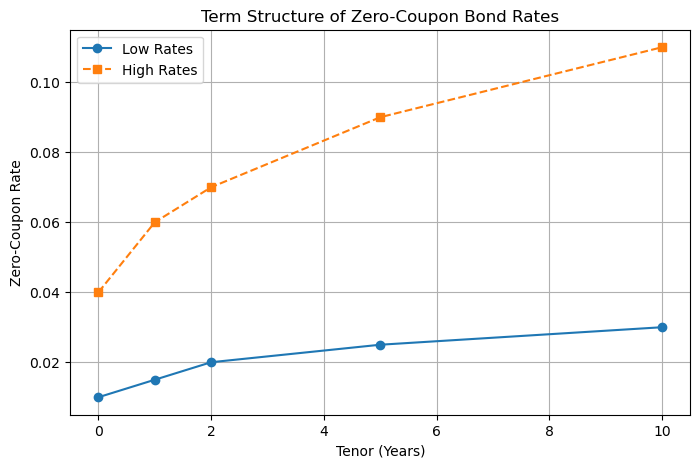

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame
rates = pd.DataFrame({
    'Low': [0.01, 0.015, 0.02, 0.025, 0.03],
    'High': [0.04, 0.06, 0.07, 0.09, 0.11],
    'Tenor': [0, 1, 2, 5, 10]
}).set_index(['Tenor'])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(rates.index, rates['Low'], marker='o', linestyle='-', label="Low Rates")
plt.plot(rates.index, rates['High'], marker='s', linestyle='--', label="High Rates")

# Labels and title
plt.xlabel("Tenor (Years)")
plt.ylabel("Zero-Coupon Rate")
plt.title("Term Structure of Zero-Coupon Bond Rates")
plt.legend()
plt.grid(True)

# **Force the plot to display**
plt.show()


We often work with spot rates, such as the swap curve, but for proper treatment of value changes, we want a zero-coupon curve.  A spot curve has the property that the present value of a coupon bond with coupons equal to the quoted rate is 1.0.  We can use that fact to construct a spot curve out of the zero curve.

In [11]:
def spot_rate(zcb, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0] == 0:
        sr = None
    else:
        r = np.interp(times, zcb.index.values, zcb.values)  # Linear interpolation
        coupons_pv_x = 0.5 * np.exp(-r * times).sum()
        final_pv = np.exp(-tenor * r[-1])
        sr = (1.0 - final_pv) / coupons_pv_x  # Solves x + c * delta = 1.0
    return sr

# Compute spot rates from zero-coupon bond rates
def compute_spot_rates(zcb_rates):
    spot = zcb_rates.copy()
    for curve in zcb_rates.columns:
        zcb = zcb_rates[curve]
        for tenor, rate in zcb.items():  # Updated to .items() to avoid FutureWarning
            if tenor > 0.001:
                spot[curve][tenor] = spot_rate(zcb, tenor)
    return spot

# Compute bond price
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0] == 0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values)  # Linear interpolation
        p = np.exp(-tenor * r[-1]) + 0.5 * coupon_rate * np.exp(-r * times).sum()
    return p

In [9]:
def spot_rate(zcb, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        sr = None
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        coupons_pv_x = 0.5*np.exp(-r*times).sum()
        final_pv = np.exp(-tenor*r[-1])
        sr = (1.0 - final_pv) / coupons_pv_x # Solves x + c * delta = 1.0
    return sr
def compute_spot_rates(zcb_rates):
    spot = zcb_rates.copy()
    for curve in zcb_rates.columns:
        zcb = zcb_rates[curve]
        for tenor, rate in zcb.iteritems():
            if tenor>0.001:
                spot[curve][tenor] = spot_rate(zcb, tenor)
    return spot


Pricing a bond, with its coupons, on a zero curve is quite simple

In [19]:
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.25)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.25 * coupon_rate * np.exp(-r*times).sum()
    return p



Let's look at the zero curves we obtain from our spot rates in the swap curve above

            Low      High
Tenor                    
0      0.010000  0.040000
1      0.015047  0.060755
2      0.020037  0.070741
5      0.024962  0.089391
10     0.029666  0.104870
Bond price on this curve (should be 1.0): 1.000000


C:\Users\vince\AppData\Local\Temp\ipykernel_18624\504838571.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  spot[curve][tenor] = spot_rate(zcb, tenor)


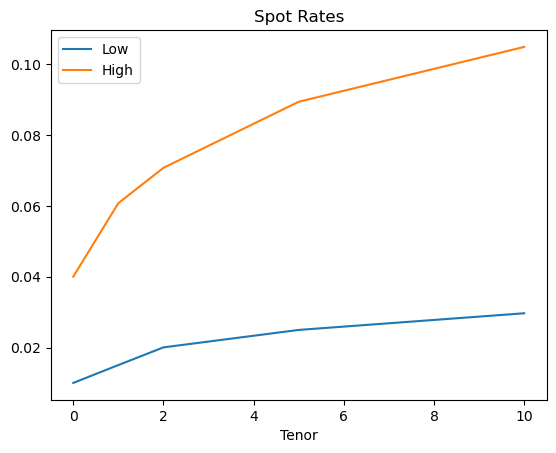

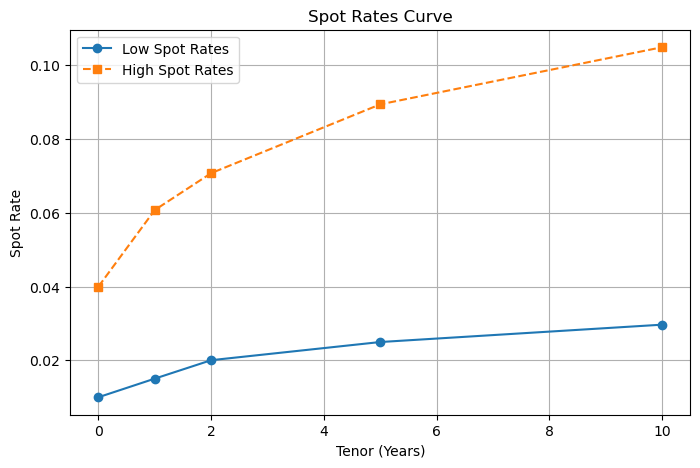

In [13]:
spot_rates = compute_spot_rates(rates)
print(spot_rates)

# Compute bond price
bond_price_result = bond_price(rates['High'], coupon_rate=spot_rates['High'][5], tenor=5)
print(f"Bond price on this curve (should be 1.0): {bond_price_result:.6f}")

# Plot the spot rates
plt.figure(figsize=(8, 5))
plt.plot(spot_rates.index, spot_rates['Low'], marker='o', linestyle='-', label="Low Spot Rates")
plt.plot(spot_rates.index, spot_rates['High'], marker='s', linestyle='--', label="High Spot Rates")

# Labels and title
plt.xlabel("Tenor (Years)")
plt.ylabel("Spot Rate")
plt.title("Spot Rates Curve")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

and now the differences

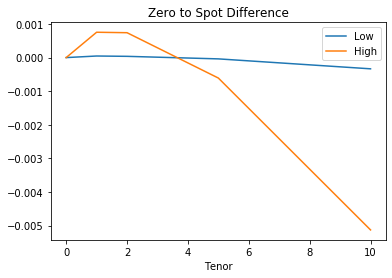

In [5]:
sp = (spot_rates-rates).plot(title="Zero to Spot Difference")

## ZCB Rates From Spot

To go from a spot curve to a ZCB curve, we have to compute the points one at a time.  The first one is the same as the zero rate.  Latter points are computed by bootstrapping, where we have zero rates for the previous tenor and just need to compute one new one at a time.  We proceed forward in tenors until the curve has been completely "stripped" in this manner.

In [20]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor in spot.index:  # Use .index instead of .iteritems()
            spot_rate = spot[tenor]
            if tenor > 0.001:
                times = np.arange(tenor - 0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5 * spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values)  # Linear interpolation
                preceding_coupons_val = (coupon_half_yr * np.exp(-z * times)).sum()
                zcb_rates.at[tenor, curve] = -np.log((1 - preceding_coupons_val) / (1 + coupon_half_yr)) / tenor
    return zcb_rates

z_rate = compute_zcb_curve(spot_rates)


In [ ]:
s_t = spot_rates.T





In [28]:
spot_rates.T

Tenor,0,1,2,5,10
Low,0.01,0.015047,0.020037,0.024962,0.029666
High,0.04,0.060755,0.070741,0.089391,0.104870


In [30]:
def process_spot_to_zcb(rates_df):
    """
    Converts spot rates to zero-coupon bond rates and returns a DataFrame
    with the same indices (Low, High), columns (Tenors), and dimensions as the input rates_df.

    Parameters:
    rates_df (pd.DataFrame): DataFrame with spot rates, where indices are different curves (e.g., Low, High)
                             and columns are tenors (e.g., 0.5, 1, 5, 10).

    Returns:
    pd.DataFrame: DataFrame with computed zero-coupon bond rates, maintaining the original structure.
    """
    # Convert column names (tenors) to numeric values
    tenors = rates_df.columns.astype(float)

    # Compute zero-coupon bond (ZCB) rates from spot rates
    def compute_zcb_curve(spot_rates_curve):
        zcb_rates = spot_rates_curve.copy()
        for index in spot_rates_curve.index:  # Now iterating over index (Low, High)
            spot = spot_rates_curve.loc[index]
            for tenor in tenors:
                spot_rate = spot[tenor]
                if tenor > 0.001:
                    times = np.arange(tenor - 0.5, 0, step=-0.5)[::-1]
                    coupon_half_yr = 0.5 * spot_rate
                    z = np.interp(times, tenors, zcb_rates.loc[index].values)  # Linear interpolation
                    preceding_coupons_val = (coupon_half_yr * np.exp(-z * times)).sum()
                    zcb_rates.at[index, tenor] = -np.log((1 - preceding_coupons_val) / (1 + coupon_half_yr)) / tenor
        return zcb_rates

    # Compute discount factors from ZCB rates
    def compute_discount_factors(zcb_curve):
        discount_factors = zcb_curve.copy()
        for index in zcb_curve.index:  # Now iterating over index (Low, High)
            for tenor in tenors:
                zero_rate = zcb_curve.at[index, tenor]
                discount_factors.at[index, tenor] = np.exp(-zero_rate * tenor)  # Continuous discounting formula
        return discount_factors
    
    zcb_rates = compute_zcb_curve(rates_df)

    # Step 2: Compute discount factors from ZCB rates
    discount_factors = compute_discount_factors(zcb_rates)

    return discount_factors


In [31]:
proc_r = process_spot_to_zcb(spot_rates.T)

proc_r

Tenor,0,1,2,5,10
Low,1.0,0.985112,0.960790,0.882493,0.740677
High,1.0,0.941770,0.869375,0.637444,0.328882


In [34]:
z_rate['Low']

Tenor
0     0.010000
1     0.015000
2     0.020000
5     0.025001
10    0.030019
Name: Low, dtype: float64

In [ ]:
bond_price(z_rate['Low'], 0.025, 5)

0.034967433984979715